In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as r
import scipy.io as sio
import math
import sklearn.decomposition
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

## Helper functions

In [19]:
def load_data(path, col_name):
    """
    Load input data from matlab file.
    
    Parameters
    ----------
    path : String
        The relative path of matlab file    
    col_name : String
        Label of the input data within the
        file
    
    Returns
    -------
    Pandas DataFrame
        Contains the input data
    """
    data = sio.loadmat(path)
    data = pd.DataFrame(data['Y'])
    
    return data

def generate_centers(X, k):
    """
    Chooses k input data points at random from
    the given data
    
    Parameters
    ----------
    X : N x D matrix
        where N is the total number of input data
        points and D is the number of features
    k : Integer
        Number of centers to be generated
    
    Returns
    -------
    List
        Containing k data points
    """
    
    # Generate a list of k random indices
    indices = np.random.randint(0, X.shape[0], k)
    
    # Extract the rows corresponding to the above
    # indices and return
    return X[indices]

def compute_distance(x, y):
    """
    Computes the euclidean distance between
    two points x and y
    
    Parameters
    ----------
    x : 1 x D matrix
        The first point
    y : 1 x D matrix
        The second point
    
    Returns
    -------
    Double
        The euclidean distance between the two
        points
    """
    z = np.power((x - y), 2)
    z = np.sum(z)
    
    return np.power(z, 0.5)

def compute_weight(x, y, v):
    """
    Computes the gaussian weight between
    two points x and y
    
    Parameters
    ----------
    x : 1 x D matrix
        The first point
    y : 1 x D matrix
        The second point
    v : Double
        The variance
    
    Returns
    -------
    Double
        The weight between these two points
        calculated using the gaussian kernel
        function
    """
    return np.exp((-(np.linalg.norm(x - y) ** 2)) / (2 * v))

def plot_data(X, data_centers):
    
    # Add cluster centers to data points
    C = np.matrix(data_centers).T
    X = np.hstack((X, C))
    data = pd.DataFrame(X, columns=['x1', 'x2', 'c'])
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    # Draw the plots
    ax.scatter(data.x1, data.x2, label='Data', c=data.c * 10)
    
    # Set extra properties for readability
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('x1 vs. x2')

def plot_mse(M):
    iters = [(i + 1) for i in range(len(M))]
    plt.plot(iters, M, 'k-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('MSE')

def compute_mse(clustered_data, centers):
    """
    Calculates the mean squared error for the
    clustering scheme specified
    
    Parameters
    ----------
    clustered_data : List<List<(1 x D)>>
        Data points grouped by their cluster
        centers
    centers : k x D matrix
        The k cluster centers
    
    Returns
    -------
    Double
        The mean squared error
    """
    
    mse = 0
    
    for i in range(0, len(centers)):
        
        # Get the cluster center and points in this cluster
        curr_center = np.matrix(centers[i])
        curr_cluster = clustered_data[i]
        
        # Calculate the squared error for each point
        for j in range(0, len(curr_cluster)):
            curr_point = np.matrix(curr_cluster[j])
            mse += compute_distance(curr_point, curr_center)
    
    return mse

## PCA

In [20]:
def pca(X, d):
    """
    Performs Principal Component Analysis on the
    given data to reduce its dimensions.
    
    Parameters
    ----------
    X : D x N matrix
        where N is the number of data points and
        D is the ambient dimension
    d : Integer
        Dimensionality of the low-dimensional
        representation
    
    Returns
    -------
    D x d matrix
        The basis of the low-dimensional subspace
    1 x d matrix
        The mean of the subspace
    d x N matrix
        The low dimensional representation of the
        input data
    """
    
    X = X.T

    # Do mean normalization
    M_X = np.sum(X, axis = 0)
    M_X = M_X / X.shape[0]
    X = X - M_X

    # Find the correlation matrix
    C = (X.T * X) / X.shape[0]

    # Do eigenvalue decomposition and get hold of 
    # the eigenvalues (D) and eigenvectors (V) of 
    # covariance matrix
    D, V = np.linalg.eig(C)

    # Extract the top-d eigenvectors
    V = V[:, 0:d]
    
    # Represent data in this basis
    Y = X * V
    
    # Calculate the mean of low-dimensional space
    M_Y = np.sum(Y, axis=0) / Y.shape[0]
    
    return V.T, M_Y, Y.T

## K-means

In [21]:
def k_means(X, k, r):
    """
    Executes the K-means algorithm to cluster the
    data into k clusters. The underlying algorithm
    uses multiple random initializations to circle
    in on the best possible clustering scheme.
    
    Parameters
    ----------
    X : N x D matrix
        where N is the number of data points and
        D is the ambient dimension
    k : Integer
        The desired number of clusters
    r : Integer
        The desired number of repititions with
        different random initializations
    
    Returns
    -------
    1 x N matrix
        which contains the best clustering scheme
    """
    
    A = []
    C = []
    M = []
    
    for i in range(r):
        new_cluster_assignment, centers, mse = cluster_data(X, k)
        A.append(new_cluster_assignment)
        C.append(centers)
        M.append(mse)
    
    lowest_mse = min(M)
    best_run = M.index(lowest_mse)
    best_centers = C[best_run]
    best_cluster_assignment = A[best_run]
    
    #U, mean, Y = pca(X, 2)    
    #plot_data(Y[0:2, :].T, new_cluster_assignment)
    
    return lowest_mse, best_centers, best_cluster_assignment

def cluster_data(X, k):
    """
    Finds the best clustering scheme for the
    specified parameters
    
    Parameters
    ----------
    X : N x D matrix
        The input data
    k : Integer
        The number of cluster centers
    
    Returns
    -------
    List<Integer>
        The indices of cluster centers assigned
        to each data point
    List<(1 x D)>
        The cluster centers
    Double
        The mean squared error
    """
    centers = []  # Stores the centers
    mse = 0
    
    # Randomly choose k points from the data
    # as centers
    centers = generate_centers(X, k)
    
    old_cluster_assignment = [-1 for i in range(X.shape[0])]
    new_cluster_assignment = []
    
    while True:
        new_cluster_assignment, clusters, centers = update_cluster_centers(X, centers)
        if (np.array_equal(old_cluster_assignment, new_cluster_assignment)):
            mse = compute_mse(clusters, centers)
            break
        else:
            old_cluster_assignment = new_cluster_assignment
    
    return new_cluster_assignment, centers, mse

def update_cluster_centers(X, centers):
    """
    Clusters the data points to their nearest
    cluster centers and re-aligns the cluster
    centers to the mean of these new clusters
    
    Parameters
    ----------
    X : N x D matrix
        The input data points
    centers : k x D matrix
        The centers to which data points need
        to be clustered
    
    Returns
    -------
    List<Integer>
        Index of cluster center for each point
    List<List<(1 x D)>>
        The points clustered to their new
        centers
    List<(1 x D)>
        The updated cluster centers
    """
    
    k = len(centers)
    N = X.shape[0]
    cluster_assignment = []  # Stores the index of the center for each point
    
    # Initialize variable to store points by clusters
    clusters = []
    for i in range(0, k):
        clusters.append([])
    
    # Assign each point to nearest cluster center
    for i in range(0, N):
        curr_x = X[i]
        
        # Initialize
        closest_center = -1
        dist_to_center = -1
        
        for j in range(0, k):
            curr_center = centers[j]
            curr_dist = compute_distance(curr_x, curr_center)
            
            if (dist_to_center == -1 or 
                dist_to_center > curr_dist):
                
                # Re-assign this point to the
                # current cluster center
                
                closest_center = j
                dist_to_center = curr_dist
        
        # Assign this point to its new cluster
        # center
        cluster_assignment.append(closest_center)
        clusters[closest_center].append(curr_x)
    
    # Re-initialize cluster centers
    for i in range(0, k):
        member_count = len(clusters[i])
        new_center = np.sum(clusters[i], axis = 0) / member_count
        centers[i] = new_center
    
    return cluster_assignment, clusters, centers

## Spectral Clustering

In [22]:
def generate_laplacian(W):
    """
    Generates the laplacian matrix for the
    given data matrix
    
    Parameters
    ----------
    W : N x N matrix
        The weight matrix
    
    Returns
    -------
    L : N x N matricex
        The generated laplacian
    """
    N = W.shape[0]
    
    # Initialize the degree matrix
    D = np.diag(np.sum(W, axis = 0).getA1())
    
    # Calculate the laplacian
    L = D - W
    
    # Normalize L
    I = np.identity(N)
    D = np.linalg.inv(D)
    D = np.sqrt(D)
    L = I - D * W * D
    
    return L

def generate_similarity_matrix(X):
    """
    Generates the similarity matrix for the
    given data
    
    Parameters
    ----------
    X : N x D matrix
        The data
    
    Returns
    -------
    An N x N matrix
        Contains the weights
    """
    X = X.T
    
    N = X.shape[0]
    
    # Run KNN and find the K nearest neighbors for each point
    nbrs = NearestNeighbors(n_neighbors=5).fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Generate similarity matrix W
    W = np.zeros((N, N))
    
    # Initialize the weights for all neighbors
    for index in indices:
        curr_index = index[0]
        curr_point = X[curr_index]
        for j in range(1, len(index)):
            curr_neighbor_index = index[j]
            curr_neighbor = X[curr_neighbor_index]
            weight = compute_weight(curr_point, curr_neighbor, 0.4)
            W[curr_index][curr_neighbor_index] = weight
            W[curr_neighbor_index][curr_index] = weight
    
    return np.matrix(W)

def spectral(W, k):
    """
    Executes the Spectral Clustering algorithm to
    cluster the data into k clusters
    
    Parameters
    ----------
    W : N x N matrix
        where N is the number of data points
        The similarity matrix
    k : Integer
        The desired number of clusters
    
    Returns
    -------
    Double
        The mean square error
    1 x k matrix
        The cluster centers
    1 x N matrix
        Cluster assignments for all points
    """
    
    # Compute the laplacian matrix
    L = generate_laplacian(W)
    
    # Perform eigenvalue decomposition of the laplacian
    # E - Eigenvalues, V - Eigen vectors
    E, V = np.linalg.eig(L)
    
    # Extract the bottom k eigen vectors
    E_sorted = E.argsort()
    E_sorted = E_sorted[:k]
    
    vec1 = np.matrix(V[:,E_sorted[0]])
    vec2 = np.matrix(V[:,E_sorted[1]])
    
    top_V = np.concatenate((vec1, vec2), axis=1)
    top_V = np.array(top_V)
    
    # Run K-means on the extracted vectors
    return k_means(top_V, 2, 5)

In [24]:
def execute():
    data = load_data("dataset2.mat", 'Y')
    X = np.matrix(data.values)
    W = generate_similarity_matrix(X)

    # Run spectral clustering
    mse, centers, cluster_assignments = spectral(W, 2)

    # Run PCA and reduce the number of dimensions to 2
    V, M, Y = pca(X, 2)

    plot_data(Y.T, cluster_assignments)

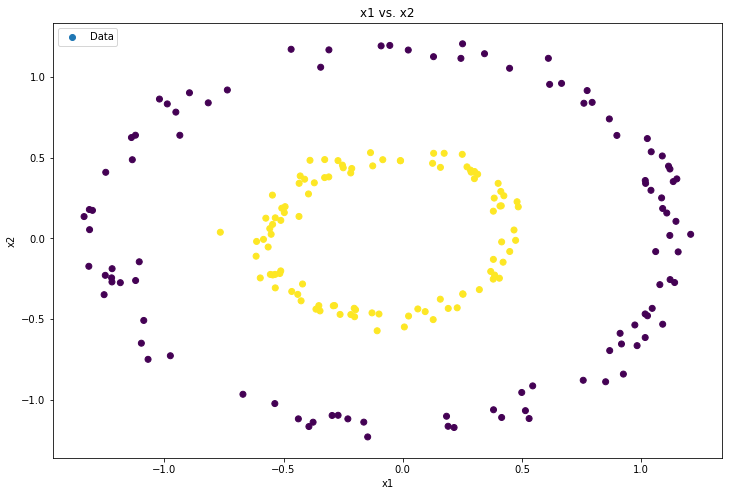

In [25]:
execute()